In [2]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [3]:
# Basics
import tensorflow as tf
import pandas as pd
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_model import *  # Load Models
from src.models.DRN.DRN_train import *
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models#
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-13 17:12:15.417392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-13 17:12:15.417434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 1. Loading Data and Splitting

In [4]:
# Load all training data and validation data of each variable
train_var_denormed, val_var_denormed = ldpd.load_data_all_train_val_proc_denorm()
# Load all test data of each variable:
test_var_denormed = ldpd.load_data_all_test_proc_denorm()

all_var_denormed = [train_var_denormed, val_var_denormed, test_var_denormed]

<IPython.core.display.Javascript object>

In [5]:
# Split all 3 datasets into X and y for each lead_time
dat_X_train_lead_all_denorm, dat_y_train_lead_all_denorm = split_var_lead(
    train_var_denormed
)
dat_X_val_lead_all_denorm, dat_y_val_lead_all_denorm = split_var_lead(val_var_denormed)

dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(
    test_var_denormed
)

<IPython.core.display.Javascript object>

### 2. Heatmap of average values

In [31]:
def visualize_val_test_hm(mean_std = 0, var_num = 5, lead_time = 0):
    fig, ax = plt.subplots(1, 2, figsize=(17, 17))

    val_data_mean = dat_X_val_lead_all_denorm[var_num][lead_time].isel(mean_std=mean_std).mean(dim='forecast_date')
    test_data_mean = dat_X_test_lead_all_denorm[var_num][lead_time].isel(mean_std=mean_std).mean(dim='forecast_date')

    # Calculate common scale for both heatmaps
    vmin = min(val_data_mean.min(), test_data_mean.min())
    vmax = max(val_data_mean.max(), test_data_mean.max())

    im = ax[0].imshow(
        val_data_mean.values,
        cmap="viridis",
        vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[0].set_title(f"Average Colormap WS predictions validation, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[0], shrink=0.5).set_label("WS in Kelvin")

    im = ax[1].imshow(
        test_data_mean.values,
        cmap="viridis",
        vmin=vmin, vmax=vmax,  # Use common scale
    )
    ax[1].set_title(f"Average Colormap WS predictions testing, lead_time: {lead_time}")
    fig.colorbar(im, ax=ax[1], shrink=0.5).set_label("WS in Kelvin")

    plt.show()


<IPython.core.display.Javascript object>

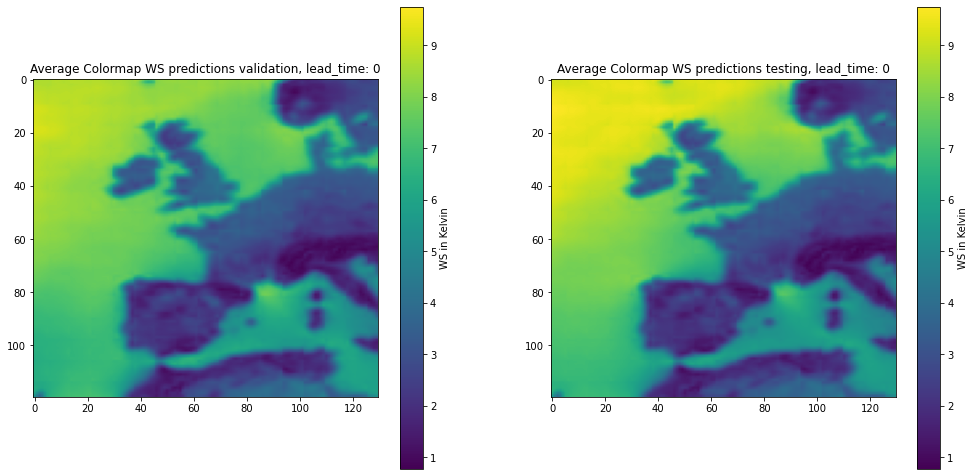

<IPython.core.display.Javascript object>

In [32]:
visualize_val_test_hm()

### 3. Histograms

In [44]:
def visualize_val_test_hist(mean_std = 0, var_num = 5, lead_time = 0):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    val_data_mean_per_day = dat_X_val_lead_all_denorm[var_num][lead_time].isel(mean_std=mean_std).mean(dim=['lat', 'lon'])
    test_data_mean_per_day = dat_X_test_lead_all_denorm[var_num][lead_time].isel(mean_std=mean_std).mean(dim=['lat', 'lon'])

    # Calculate common scale for both histograms
    data_min = min(val_data_mean_per_day.min(), test_data_mean_per_day.min())
    data_max = max(val_data_mean_per_day.max(), test_data_mean_per_day.max())
    bins = np.linspace(data_min, data_max, 20)  # adjust number of bins if necessary

    ax[0].hist(val_data_mean_per_day.values, bins=bins, color='blue', alpha=0.7)
    ax[0].set_title(f"Histogram of daily means - validation, lead_time: {lead_time}")
    ax[0].set_xlabel('Wind speed in m/s')
    ax[1].hist(test_data_mean_per_day.values, bins=bins, color='red', alpha=0.7)
    ax[1].set_title(f"Histogram of daily means - testing, lead_time: {lead_time}")
    ax[1].set_xlabel('Wind speed in m/s')
    plt.show()


<IPython.core.display.Javascript object>

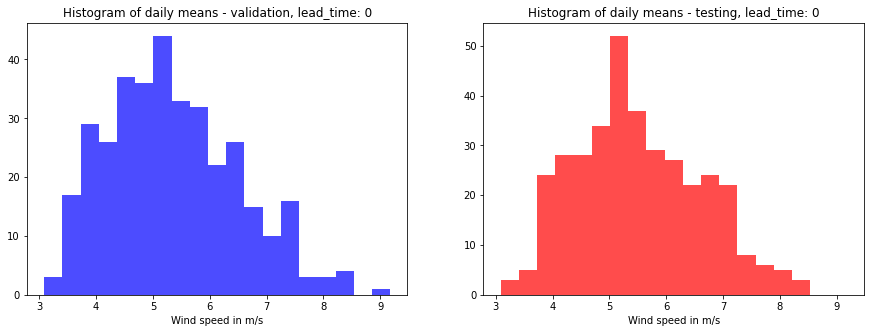

<IPython.core.display.Javascript object>

In [47]:
visualize_val_test_hist()